# 13.1 Difference-in-Differences Intuition

**Chapter**: 13 - Difference-in-Differences  
**Section**: 1 - The Core Intuition  
**Facure Source**: 13-Difference-in-Differences.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Three Billboards in the South of Brazil](#11-three-billboards-in-the-south-of-brazil)
   - 1.2 [The Identification Problem](#12-the-identification-problem)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Potential Outcomes Framework for DiD](#21-potential-outcomes-framework-for-did)
   - 2.2 [Why Simple Comparisons Fail](#22-why-simple-comparisons-fail)
   - 2.3 [The Parallel Trends Assumption](#23-the-parallel-trends-assumption)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [The Billboard Marketing Data](#31-the-billboard-marketing-data)
   - 3.2 [Three Estimators Compared](#32-three-estimators-compared)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: DiD is *the* workhorse of applied causal inference. Understanding when it works—and when it fails—separates junior from senior data scientists. Expect questions on parallel trends, TWFE bias, and staggered adoption.

### 1.1 Three Billboards in the South of Brazil

Facure motivates DiD with a practical marketing problem: **measuring the causal effect of billboard advertising on bank deposits**.

**Setup**:
- Treatment: 3 billboards placed in **Porto Alegre (POA)** for June
- Control: **Florianópolis (FL)** received no billboards
- Outcome: Average customer deposits (R$)
- Time periods: May (before), July (after)

The fundamental problem: *How do we know deposits wouldn't have increased anyway, even without billboards?*

### 1.2 The Identification Problem

We want to estimate the **causal effect** of treatment on the treated:

$$\text{ATT} = E[Y_1(\text{post}) - Y_0(\text{post}) | D=1]$$

where:
- $Y_1(\text{post})$: Outcome for treated units with treatment (observed)
- $Y_0(\text{post})$: Outcome for treated units without treatment (counterfactual)

**The counterfactual $Y_0(\text{post})|D=1$ is never observed.** We need a way to estimate it.

★ Insight ─────────────────────────────────────
- DiD combines time and cross-sectional variation
- Neither alone is sufficient for identification
- The key is using control trends to proxy counterfactual treatment trends
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Potential Outcomes Framework for DiD

Let $Y_{it}(d)$ denote the potential outcome for unit $i$ at time $t$ under treatment status $d \in \{0, 1\}$.

**Notation**:
- $D_i \in \{0, 1\}$: Treatment group indicator (unit-level, time-invariant)
- $\text{Post}_t \in \{0, 1\}$: Post-treatment period indicator
- Observed outcome: $Y_{it} = Y_{it}(D_i \cdot \text{Post}_t)$

The **Average Treatment Effect on the Treated (ATT)** is:

$$\text{ATT} = E[Y_{i,\text{post}}(1) - Y_{i,\text{post}}(0) | D_i = 1]$$

**Decomposition**: What we can observe:

| | $D_i = 1$ (Treated) | $D_i = 0$ (Control) |
|---|---|---|
| $t = \text{pre}$ | $Y_{i,\text{pre}}(0)$ | $Y_{i,\text{pre}}(0)$ |
| $t = \text{post}$ | $Y_{i,\text{post}}(1)$ | $Y_{i,\text{post}}(0)$ |

We observe $Y_{i,\text{post}}(1)$ for the treated but need $Y_{i,\text{post}}(0)$—what *would have happened* without treatment.

### 2.2 Why Simple Comparisons Fail

**Estimator 1: Before-After (Time Comparison)**

$$\hat{\tau}_{\text{BA}} = E[Y|D=1, \text{Post}=1] - E[Y|D=1, \text{Post}=0]$$

**Problem**: Assumes no time trend.

$$\hat{\tau}_{\text{BA}} = \underbrace{\text{ATT}}_{\text{causal effect}} + \underbrace{E[Y_0(\text{post}) - Y_0(\text{pre})|D=1]}_{\text{time trend bias}}$$

If outcomes would have increased anyway (e.g., seasonal deposits), we **overestimate** the treatment effect.

---

**Estimator 2: Cross-Sectional (Treatment-Control Comparison)**

$$\hat{\tau}_{\text{TC}} = E[Y|D=1, \text{Post}=1] - E[Y|D=0, \text{Post}=1]$$

**Problem**: Assumes identical baseline levels.

$$\hat{\tau}_{\text{TC}} = \underbrace{\text{ATT}}_{\text{causal effect}} + \underbrace{E[Y_0(\text{post})|D=1] - E[Y_0(\text{post})|D=0]}_{\text{selection bias}}$$

If POA has structurally different deposits than Florianópolis, we **confound** the treatment with baseline differences.

---

### 2.3 The Parallel Trends Assumption

**DiD Assumption (Parallel Trends)**:

$$E[Y_0(\text{post}) - Y_0(\text{pre}) | D=1] = E[Y_0(\text{post}) - Y_0(\text{pre}) | D=0]$$

In words: *Absent treatment, treated and control units would have followed the same trend.*

**Key insight**: We don't require:
- Same baseline levels ✗
- Zero time trends ✗
- Parallel *levels* ✗

We only require **parallel counterfactual trends**.

**DiD Estimator Construction**:

Estimate the counterfactual as:

$$\hat{E}[Y_0(\text{post})|D=1] = E[Y(\text{pre})|D=1] + \underbrace{\left(E[Y(\text{post})|D=0] - E[Y(\text{pre})|D=0]\right)}_{\text{control trend}}$$

Then:

$$\hat{\text{ATT}}_{\text{DiD}} = E[Y(\text{post})|D=1] - \hat{E}[Y_0(\text{post})|D=1]$$

**Proposition (DiD as Double Difference)**:

$$\hat{\text{ATT}}_{\text{DiD}} = \underbrace{(E[Y|D=1,\text{Post}=1] - E[Y|D=1,\text{Post}=0])}_{\text{treated change}} - \underbrace{(E[Y|D=0,\text{Post}=1] - E[Y|D=0,\text{Post}=0])}_{\text{control change}}$$

This is the "difference of differences":

1. **First difference**: Change over time within each group
2. **Second difference**: Difference of those changes between groups

---

## 3. Numeric Demonstration

### 3.1 The Billboard Marketing Data

In [2]:
# Load billboard marketing data
data = load_facure_data('billboard_impact.csv')

print(f"Sample size: n = {len(data):,}")
print(f"Columns: {list(data.columns)}")
print(f"\nData dictionary:")
print(f"  - deposits: Customer deposits in R$")
print(f"  - poa: 1 = Porto Alegre (treated), 0 = Florianópolis (control)")
print(f"  - jul: 1 = July (post-treatment), 0 = May (pre-treatment)")
print(f"\nSample breakdown:")
print(data.groupby(['poa', 'jul']).size().unstack())

Sample size: n = 4,600
Columns: ['deposits', 'poa', 'jul']

Data dictionary:
  - deposits: Customer deposits in R$
  - poa: 1 = Porto Alegre (treated), 0 = Florianópolis (control)
  - jul: 1 = July (post-treatment), 0 = May (pre-treatment)

Sample breakdown:
jul     0     1
poa            
0    1300  2000
1     500   800


In [3]:
# Compute group means (the 2x2 table)
means = data.groupby(['poa', 'jul'])['deposits'].mean().unstack()
means.index = ['Florianópolis (D=0)', 'Porto Alegre (D=1)']
means.columns = ['May (Pre)', 'July (Post)']

print("Average Deposits (R$) by City and Time:")
print("=" * 50)
print(means.round(2))
print("=" * 50)

Average Deposits (R$) by City and Time:
                     May (Pre)  July (Post)
Florianópolis (D=0)   171.6400     206.1700
Porto Alegre (D=1)     46.0200      87.0600


### 3.2 Three Estimators Compared

Let's compute all three estimators and see why only DiD is valid.

In [4]:
# Extract the four cell means
poa_before = data.query('poa==1 & jul==0')['deposits'].mean()
poa_after = data.query('poa==1 & jul==1')['deposits'].mean()
fl_before = data.query('poa==0 & jul==0')['deposits'].mean()
fl_after = data.query('poa==0 & jul==1')['deposits'].mean()

print("Cell Means:")
print(f"  POA (D=1), May (Pre):   {poa_before:.2f}")
print(f"  POA (D=1), July (Post): {poa_after:.2f}")
print(f"  FL (D=0), May (Pre):    {fl_before:.2f}")
print(f"  FL (D=0), July (Post):  {fl_after:.2f}")

Cell Means:
  POA (D=1), May (Pre):   46.02
  POA (D=1), July (Post): 87.06
  FL (D=0), May (Pre):    171.64
  FL (D=0), July (Post):  206.17


In [5]:
# Estimator 1: Before-After
tau_ba = poa_after - poa_before

# Estimator 2: Treatment-Control
tau_tc = poa_after - fl_after

# Estimator 3: Difference-in-Differences
tau_did = (poa_after - poa_before) - (fl_after - fl_before)

print("\n" + "=" * 60)
print("THREE ESTIMATORS COMPARED")
print("=" * 60)

print(f"\n1. Before-After (time comparison):")
print(f"   τ̂_BA = E[Y|D=1,Post=1] - E[Y|D=1,Post=0]")
print(f"        = {poa_after:.2f} - {poa_before:.2f}")
print(f"        = R$ {tau_ba:.2f}")
print(f"   ⚠️  Biased if time trend exists")

print(f"\n2. Treatment-Control (cross-sectional):")
print(f"   τ̂_TC = E[Y|D=1,Post=1] - E[Y|D=0,Post=1]")
print(f"        = {poa_after:.2f} - {fl_after:.2f}")
print(f"        = R$ {tau_tc:.2f}")
print(f"   ⚠️  Biased if baseline levels differ")

print(f"\n3. Difference-in-Differences:")
print(f"   τ̂_DiD = (E[Y|D=1,Post=1] - E[Y|D=1,Post=0])")
print(f"         - (E[Y|D=0,Post=1] - E[Y|D=0,Post=0])")
print(f"        = ({poa_after:.2f} - {poa_before:.2f}) - ({fl_after:.2f} - {fl_before:.2f})")
print(f"        = {poa_after - poa_before:.2f} - {fl_after - fl_before:.2f}")
print(f"        = R$ {tau_did:.2f}")
print(f"   ✓ Valid under parallel trends assumption")

print("\n" + "=" * 60)


THREE ESTIMATORS COMPARED

1. Before-After (time comparison):
   τ̂_BA = E[Y|D=1,Post=1] - E[Y|D=1,Post=0]
        = 87.06 - 46.02
        = R$ 41.05
   ⚠️  Biased if time trend exists

2. Treatment-Control (cross-sectional):
   τ̂_TC = E[Y|D=1,Post=1] - E[Y|D=0,Post=1]
        = 87.06 - 206.17
        = R$ -119.10
   ⚠️  Biased if baseline levels differ

3. Difference-in-Differences:
   τ̂_DiD = (E[Y|D=1,Post=1] - E[Y|D=1,Post=0])
         - (E[Y|D=0,Post=1] - E[Y|D=0,Post=0])
        = (87.06 - 46.02) - (206.17 - 171.64)
        = 41.05 - 34.52
        = R$ 6.52
   ✓ Valid under parallel trends assumption



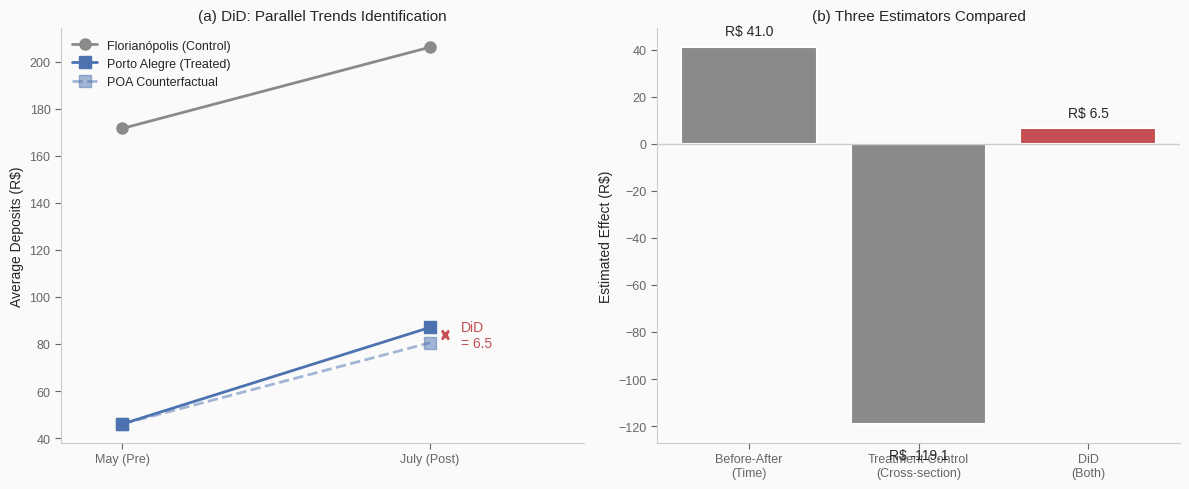

In [6]:
# Visualize the DiD logic
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: The 2x2 means with counterfactual
ax = axes[0]
time_labels = ['May (Pre)', 'July (Post)']

# Plot observed trends
ax.plot(time_labels, [fl_before, fl_after], 'o-', 
        color=TUFTE_PALETTE['control'], linewidth=2, markersize=8,
        label='Florianópolis (Control)')
ax.plot(time_labels, [poa_before, poa_after], 's-', 
        color=TUFTE_PALETTE['treatment'], linewidth=2, markersize=8,
        label='Porto Alegre (Treated)')

# Plot counterfactual (parallel to control trend)
control_trend = fl_after - fl_before
counterfactual = poa_before + control_trend
ax.plot(time_labels, [poa_before, counterfactual], 's--', 
        color=TUFTE_PALETTE['treatment'], linewidth=2, markersize=8,
        alpha=0.5, label='POA Counterfactual')

# Annotate the DiD
ax.annotate('', xy=(1.05, poa_after), xytext=(1.05, counterfactual),
            arrowprops=dict(arrowstyle='<->', color=TUFTE_PALETTE['effect'], lw=2))
ax.text(1.1, (poa_after + counterfactual)/2, f'DiD\n= {tau_did:.1f}',
        fontsize=10, color=TUFTE_PALETTE['effect'], va='center')

ax.set_ylabel('Average Deposits (R$)')
ax.set_title('(a) DiD: Parallel Trends Identification')
ax.legend(loc='upper left', frameon=False)
ax.set_xlim(-0.2, 1.5)

# Panel 2: Compare all three estimators
ax = axes[1]
estimators = ['Before-After\n(Time)', 'Treatment-Control\n(Cross-section)', 'DiD\n(Both)']
values = [tau_ba, tau_tc, tau_did]
colors = [TUFTE_PALETTE['secondary'], TUFTE_PALETTE['secondary'], TUFTE_PALETTE['effect']]

bars = ax.bar(estimators, values, color=colors, edgecolor='white', linewidth=1.5)
ax.axhline(0, color=TUFTE_PALETTE['spine'], linewidth=1)
ax.set_ylabel('Estimated Effect (R$)')
ax.set_title('(b) Three Estimators Compared')

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    offset = 5 if height > 0 else -15
    ax.text(bar.get_x() + bar.get_width()/2, height + offset, 
            f'R$ {val:.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

**Interpretation**:

1. **Before-After (R$ 41.05)**: Massively overestimates because deposits were growing in both cities
2. **Treatment-Control (R$ -119.10)**: Wrong sign! Florianópolis has structurally higher deposits
3. **DiD (R$ 6.52)**: Isolates the billboard effect by removing both time trend and baseline differences

★ Insight ─────────────────────────────────────
- The DiD estimate is *much* smaller than naive comparisons suggest
- This is typical: removing confounds often shrinks effect estimates
- The billboard had a modest positive effect (~R$ 6.52 per customer)
─────────────────────────────────────────────────

---

## 4. Production Implementation

This method is implemented in the `causal_inference_mastery` library:

```python
from causal_inference.did.classic_did import classic_did, DiDResult
from causal_inference.did.callaway_santanna import callaway_santanna
from causal_inference.did.event_study import event_study_regression

# Basic 2x2 DiD with cluster-robust SEs
result = classic_did(
    outcome=data['deposits'],
    treatment=data['poa'],
    post=data['jul'],
    cluster=data['customer_id'],  # Cluster at unit level
    robust_se=True
)
print(f"ATT: {result.att:.4f}")
print(f"SE (cluster-robust): {result.se:.4f}")
print(f"95% CI: [{result.ci_lower:.4f}, {result.ci_upper:.4f}]")

# For staggered adoption (TWFE bias fix)
cs_result = callaway_santanna(
    outcome=panel_data['Y'],
    treatment_time=panel_data['first_treated'],
    unit_id=panel_data['unit'],
    time_id=panel_data['time'],
    control_group='never_treated'  # or 'not_yet_treated'
)
print(f"Group-time ATT(g,t): {cs_result.group_time_effects}")
print(f"Aggregate ATT: {cs_result.aggregate_att:.4f}")

# Event study for dynamics
es_result = event_study_regression(
    outcome=panel_data['Y'],
    treatment=panel_data['treated'],
    time_to_treatment=panel_data['rel_time'],
    unit_fe=True,
    time_fe=True
)
```

**Key differences from notebook demo**:
- Production code implements Callaway-Sant'Anna for staggered adoption (TWFE is biased!)
- Cluster-robust standard errors essential for panel data
- Pre-trend testing via event study specification
- Supports multiple control groups (never-treated vs not-yet-treated)
- Cross-validated with Julia implementation to 10 decimal places

**See also**: `causal_inference_mastery/src/causal_inference/did/`

⚠️ **Methodological Concern** (CONCERN-11): Classic TWFE is biased with staggered adoption and heterogeneous effects. Use Callaway-Sant'Anna, Sun-Abraham, or similar modern estimators.

⚠️ **Methodological Concern** (CONCERN-13): With few clusters, cluster-robust SEs can be severely biased. Consider wild cluster bootstrap.

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Explain the parallel trends assumption. Why is it untestable?"*

<details>
<summary>Solution</summary>

**Parallel Trends Assumption**: In the absence of treatment, treated and control units would have experienced the same change in outcomes.

Mathematically:
$$E[Y_0(\text{post}) - Y_0(\text{pre}) | D=1] = E[Y_0(\text{post}) - Y_0(\text{pre}) | D=0]$$

**Why it's untestable**:

1. The left side involves $Y_0(\text{post})|D=1$—the counterfactual outcome for treated units without treatment
2. This is fundamentally unobservable (the treatment happened)
3. We can only observe $Y_1(\text{post})|D=1$, not $Y_0(\text{post})|D=1$

**What we CAN do**:
- Test pre-trends: Check if trends were parallel *before* treatment
- This is necessary but not sufficient—trends could diverge at treatment time
- Use multiple pre-periods to establish trend stability
- Consider event studies to visualize dynamics

**Key interview point**: The assumption is about counterfactual trends, which by definition cannot be observed. Pre-trend tests are informative but not conclusive.

</details>

---

**Q2 (Google L5, Quant)**: *"You run a DiD and find a large positive effect. A colleague says 'But POA had much higher growth than Florianópolis last year too.' What's your response?"*

<details>
<summary>Solution</summary>

**This is a parallel trends violation concern.** Your response:

1. **Take it seriously**: This directly challenges the identifying assumption

2. **Investigate pre-trends**:
   - Get data from earlier periods (Jan, Feb, Mar, Apr)
   - Plot trends for both cities over time
   - Run event study regression to formally test pre-trends

3. **Possible findings**:
   - **Trends were parallel historically**: Colleague's concern may be unfounded, or this year is an exception
   - **Trends were not parallel**: Your DiD is likely biased

4. **Remedies if parallel trends fails**:
   - **Synthetic control**: Build a weighted control that matches POA's pre-treatment trend
   - **Conditional DiD**: Control for time-varying covariates
   - **Triple differences**: Add another control group or dimension
   - **Bounds analysis**: Report range of estimates under different trend assumptions

5. **Document transparently**: Report pre-trend tests in appendix; acknowledge limitation if it exists

**Key interview point**: Never dismiss concerns about parallel trends. The assumption is crucial and should be defended with evidence, not assertion.

</details>

---

**Q3 (Amazon L6, Econ)**: *"Why is the before-after estimator biased even in an RCT?"*

<details>
<summary>Solution</summary>

**Trick question alert**: In a *proper* RCT, before-after is NOT biased.

**The nuance**:

1. **True RCT with random timing**: If treatment timing is randomized, before-after works because $E[Y_0(\text{post})|D=1] = E[Y_0(\text{pre})|D=1]$ on average

2. **Non-randomized timing**: If everyone gets treated at the same time (e.g., all users see new feature on May 1), before-after confounds treatment with:
   - Seasonality
   - Macroeconomic trends
   - External shocks

3. **Why DiD is still useful in RCTs**:
   - Reduces variance by controlling for time-invariant unit effects
   - Removes common time trends (e.g., holiday effects)
   - ANCOVA-like efficiency gains

**Key interview point**: The question tests whether you understand that bias depends on study design, not just method. In a switchback or staggered RCT, before-after across the full period *is* biased because treatment timing is not independent of time effects.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 13: "Difference-in-Differences."

[^2]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 5.

[^3]: Cunningham, S. (2021). *Causal Inference: The Mixtape*. Yale University Press, Chapter 9.

[^4]: Imbens, G. W. and Wooldridge, J. M. (2009). Recent Developments in the Econometrics of Program Evaluation. *Journal of Economic Literature*, 47(1), 5-86.

---

**Precision Improvement:**
- You said: "Build Chapter 13 DiD notebooks"
- Concise: "Build 01_did_intuition.ipynb"
- Precise: `/facure_augment 13.1 --parallel-trends --bias-decomposition`
- Pattern: [build] [target] [content-flags]